                                OLS Regression Results                               
Dep. Variable:     avg_delivery_duration_min   R-squared:                       0.271
Model:                                   OLS   Adj. R-squared:                  0.271
Method:                        Least Squares   F-statistic:                     6174.
Date:                       Wed, 23 Apr 2025   Prob (F-statistic):               0.00
Time:                               03:17:04   Log-Likelihood:            -1.5508e+05
No. Observations:                      27498   AIC:                         3.102e+05
Df Residuals:                          27478   BIC:                         3.104e+05
Df Model:                                 19                                         
Covariance Type:                         HC3                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------

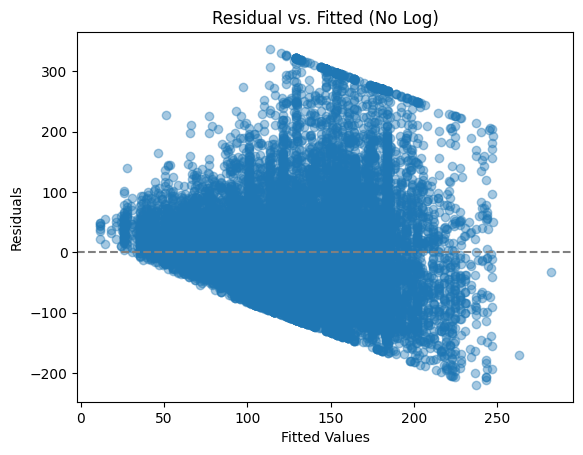

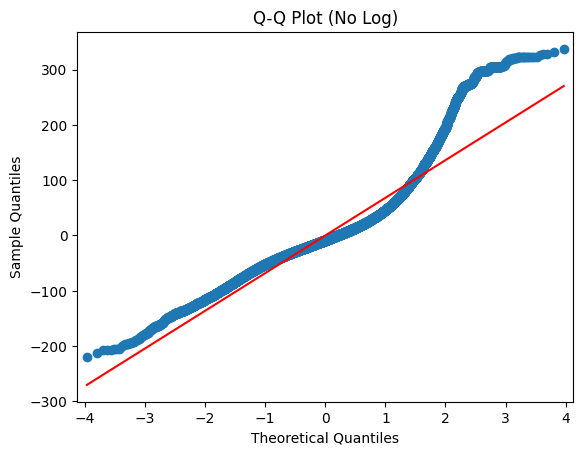

Breusch-Pagan p-value: 0.0000


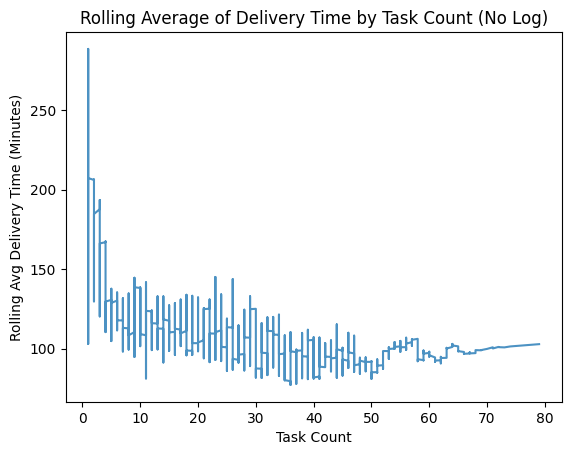

In [ ]:
"""
This is a quasi-experimental causal model, more specifically a threshold-based treatment-effect model.

Model Description: Threshold-Based Causal Regression 

Objective:
    Evaluate whether delivery performance is affected more significantly when a courier is under high task load.

Main Modeling Approach:
    - The model introduces a threshold effect using:
        - task_count_c: task_count_c = task_count - threshold
        - high_load: Binary indicator (1 if task_count > threshold)
        - task_count_c * high_load: Interaction term to detect if extra workload under high load worsens performance

    - Fixed effects are included for:
        - region_id (to control for regional delivery conditions)
        - hour_bin (to control for time-of-day variation)

Interpretation:
    - Baseline effect of task_count_c represents normal (low-load) days.
    - The interaction term shows: 
        "How much more does each additional task affect delivery time when the courier is already under 'high load?'"

!!! Threshold might be 25(Refer to the code below)
Beyond this point, assigning additional tasks no longer leads to shorter delivery times — indicating that the courier may have reached a productivity ceiling.
"""

import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np

# --- Load Data ---
df = pd.read_parquet(r"https://github.com/ISL-0111/IDS701_Team_Project/raw/refs/heads/main/Data/cleaned_data.parquet")
df["accept_hour"] = df["accept_time"].dt.hour

# --- Step 1: Filter Data for Top Regions ---
top_regions = df["region_id"].value_counts().head(14).index
df_filtered = df[df["region_id"].isin(top_regions)]

# --- Step 2: Create Daily Aggregations per Courier ---
daily_agg = (
    df_filtered.groupby(["courier_id", "accept_date"])
    .agg(
        region_id=("region_id", "first"),
        task_count=("order_id", "nunique"),
        avg_delivery_duration_min=("delivery_duration_minutes", "mean"),
        avg_distance_km=("distance_km", "mean"),
        delivery_hour_mode=("accept_hour", lambda x: x.mode()[0]),
    )
    .reset_index()
)

# --- Step 3: Set Fixed Threshold = 25 ---
threshold = 25
daily_agg["high_load"] = (daily_agg["task_count"] > threshold).astype(int)
daily_agg["task_count_c"] = daily_agg["task_count"] - threshold

# --- Time Binning ---
daily_agg["hour_bin"] = pd.cut(
    daily_agg["delivery_hour_mode"],
    bins=[0, 6, 12, 18, 24],
    labels=["Night", "Morning", "Afternoon", "Evening"],
    right=False
)

# --- Clip outliers without log transform ---
q_low, q_high = daily_agg["avg_delivery_duration_min"].quantile([0.01, 0.99])
daily_agg["avg_delivery_duration_min"] = daily_agg["avg_delivery_duration_min"].clip(lower=q_low, upper=q_high)

# --- Step 4: Linear Causal Model (no log) ---
model = smf.ols(
    formula="""
        avg_delivery_duration_min ~ task_count_c * high_load
        + avg_distance_km
        + C(region_id)
        + C(hour_bin)
    """,
    data=daily_agg
).fit(cov_type="HC3")

# --- Step 5: Summary Results ---
print(model.summary())

# --- Step 6: VIF Calculation ---
X_vif = daily_agg[["task_count_c", "high_load", "avg_distance_km"]].copy()
X_vif["interaction"] = daily_agg["task_count_c"] * daily_agg["high_load"]
X_vif = sm.add_constant(X_vif)
vif_df = pd.DataFrame({
    "feature": X_vif.columns,
    "VIF": [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
})
print(vif_df)

# --- Step 7: Diagnostic Checks ---
# Residual Plot
plt.scatter(model.fittedvalues, model.resid, alpha=0.4)
plt.axhline(y=0, color="gray", linestyle="--")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residual vs. Fitted (No Log)")
plt.show()

# Q-Q Plot
qqplot(model.resid, line="s")
plt.title("Q-Q Plot (No Log)")
plt.show()

# Breusch-Pagan Test
bp_test = het_breuschpagan(model.resid, model.model.exog)
print(f"Breusch-Pagan p-value: {bp_test[1]:.4f}")

# --- Step 8: Rolling Average Plot (for reference) ---
daily_agg_sorted = daily_agg.sort_values("task_count")
rolling_avg = daily_agg_sorted["avg_delivery_duration_min"].rolling(window=100).mean()

plt.plot(daily_agg_sorted["task_count"], rolling_avg, alpha=0.8)
plt.xlabel("Task Count")
plt.ylabel("Rolling Avg Delivery Time (Minutes)")
plt.title("Rolling Average of Delivery Time by Task Count (No Log)")
plt.show()